<a href="https://colab.research.google.com/github/Maramattia/Diabetic-Foot-Ulcer-Challenge/blob/main/MMSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install PyTorch
!pip install torch==1.12.0 torchvision --extra-index-url https://download.pytorch.org/whl/cu113
# Install MMCV
!pip install openmim
!mim install mmcv-full==1.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 3.4 MB/s 
     |████████████████████████████████| 235 kB 15.8 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu113/torch1.12.0/index.html
     |████████████████████████████████| 40.1 MB 2.2 MB/s 
     |████████████████████████████████| 190 kB 6.4 MB/s 


In [ ]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 10191, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 10191 (delta 16), reused 48 (delta 11), pack-reused 10121
Receiving objects: 100% (10191/10191), 14.46 MiB | 23.80 MiB/s, done.
Resolving deltas: 100% (7445/7445), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
     |████████████████████████████████| 578 kB 5.7 MB/s 
  Running setup.py develop for mmsegmentation


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.12.0+cu113 True
0.27.0


## Run Inference with MMSeg trained weight

In [ ]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

We need to convert the annotation into semantic map format as an image.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release'
img_dir = 'DFUC2022_train_images'
ann_dir = 'DFUC2022_train_masks'
# define class and plaette for better visualization
classes = ('background','ulcer')
palette = [[0, 0, 0], [255, 255, 255]]

In [ ]:
data = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release'
ann_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release'
for file in mmcv.scandir(ann_dir, suffix='.png'):
    seg_map = cv2.imread(osp.join(ann_dir, file),cv2.IMREAD_GRAYSCALE)
    seg_map = np.array(seg_map)
    seg_map[seg_map != 0] = 255
    seg_img = Image.fromarray(seg_map).convert('P')
    cv2.imwrite(os.path.join(data, file), seg_map)
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(osp.join(data_root, ann_dir, file.replace('.png', '.png')))

In [ ]:
img = Image.open('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/val_deeplab_sub/200137.png')

In [ ]:
print(np.unique(img))

[  0 255]


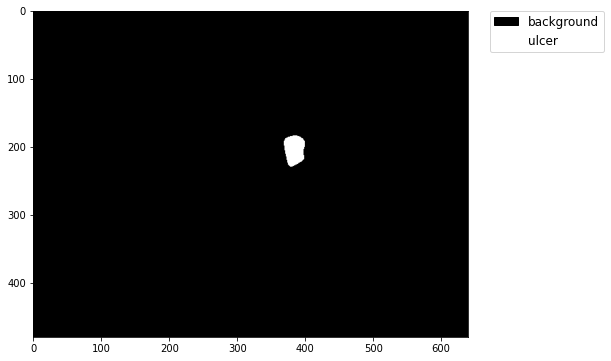

In [ ]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/DFUC2022_train_masks/101509.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [ ]:
# split train/val set randomly

split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*0.95)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])


After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [ ]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class DFUDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.jpg', seg_map_suffix='.png', ignore_index=-100, reduce_zero_label=False, split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_512x512_160k_ade20k/segformer_mit-b5_512x512_160k_ade20k_20210726_145235-94cedf59.pth -P checkpoints

In [ ]:
from mmcv import Config
cfg = Config.fromfile('configs/segformer/segformer_mit-b5_512x512_160k_ade20k.py')

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [ ]:
from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = dict(type='LN', requires_grad=True)
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
#cfg.model.auxiliary_head.num_classes = 2

cfg.device = 'cuda'

# Modify dataset type and path
cfg.dataset_type = 'DFUDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu= 16

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations',reduce_zero_label=False),
    dict(type='Resize', img_scale=(480, 480), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    #dict(type="RandomRotate", prob=0.75, degree=180),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(480, 480),
        #img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            #dict(type="RandomRotate", prob=0.75, degree=180),
            dict(type="PhotoMetricDistortion"),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
#cfg.load_from = 'checkpoints/segformer_mit-b5_512x512_160k_ade20k_20210726_145235-94cedf59.pth'
cfg.load_from = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/best_mIoU_iter_400.pth'
#cfg.resume_from =  '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/best_mIoU_iter_200.pth'
#cfg.resume_from = '/content/mmsegmentation/work_dirs/tutorial/best_mIoU_iter_200.pth'
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 35000
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.evaluation.save_best = 'mIoU'
#cfg.optimizer = dict(type='SGD', lr=0.0001, momentum=0.9, weight_decay=0.0005)
#cfg.optimizer = dict( type='Adam', lr=0.0004, weight_decay=0.0001)
cfg.checkpoint_config.interval = 200
#cfg.lr_config = dict(policy='poly', power=0.9, min_lr=0.001, by_epoch=False)
cfg.ignore_index = -100
avg_non_ignore = True

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=
    'https://download.openmmlab.com/mmsegmentation/v0.5/pretrain/segformer/mit_b5_20220624-658746d9.pth',
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        norm_cfg=dict(type='LN', requires_grad=True)),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
         

### Train and Evaluation

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]
#cfg.model.init_weights() 
# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

In [ ]:
model

In [ ]:
!cp '/content/mmsegmentation/work_dirs/tutorial/best_mIoU_iter_800.pth' '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release'

In [ ]:
import pickle
pickle.dump(model, open('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/segformer_400.pkl', 'wb'))

# **Test Image**

In [ ]:
image = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/DFUC2022_train_images/100883.jpg'

In [ ]:
result = inference_segmentor(model, image)

# **Re-Ranker**

In [ ]:
model.decode_head.sep_bottleneck[1].pointwise_conv.conv

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name].append(output.detach())
    return hook

In [ ]:
model.cfg=cfg

In [ ]:
model.decode_head.sep_bottleneck[1].pointwise_conv.conv.register_forward_hook(get_activation("init_conv"))
result=inference_segmentor(model, image)
feature = activation["init_conv"]

In [ ]:
activation

# **Boost train**

In [ ]:
from google.colab.patches import cv2_imshow
from datasets import load_metric

model.cfg = cfg
boost = []
metric = load_metric("mean_iou")

masks_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/DFUC2022_train_masks'
images_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/DFUC2022_train_images'
output_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/boost'

id2label = {0: 'background', 1: 'Ulcer'}    
label2id = {'background': 0, 'Ulcer': 1}


text_file = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/splits/train.txt'
with open(text_file) as f:
    mylist = f.read().splitlines() 

Names = sorted(mylist)

for fileName in Names:

  mask = cv2.imread(os.path.join(masks_dir, fileName +'.png'))
  image = cv2.imread(os.path.join(images_dir,fileName + '.jpg'))
  img = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/DFUC2022_train_images/' + fileName + ".jpg"  
  result = inference_segmentor(model, img)
  img = mmcv.imread(img)
  img = img.copy()
  seg = result[0]
  seg = mmcv.imresize(seg, img.shape[:2][::-1])
  palette = np.array(palette)
  assert palette.shape[1] == 3
  assert len(palette.shape) == 2
  assert 0 < 0.5 <= 1.0
  color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
  for label, color in enumerate(palette):
      color_seg[seg == label, :] = color
  # convert to BGR
  color_seg = color_seg[..., ::-1]

  output = color_seg.astype(np.uint8)

  mask_cal = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  output_cal = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
  mask_cal[mask_cal == 255] = 1
  output_cal[output_cal == 255] = 1

  metric.add(prediction=output_cal, reference=mask_cal)
  metrics = metric.compute(num_labels=len(id2label), 
                              ignore_index=-100,
                              reduce_labels=False,
    )

  if( metrics["per_category_iou"][1] < 0.8):
    boost.append(fileName)
     # of same height 
    im_h = cv2.hconcat([mask, image, output])
    # show the output image
    cv2_imshow(im_h)
    print("Ulcer_iou:", metrics["per_category_iou"][1])
    print("Mean_iou:", metrics["mean_iou"])

# **Predict**

In [ ]:
import cv2, os
from PIL import Image
from tqdm import tqdm
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import remove_small_objects
from google.colab.patches import cv2_imshow


In [ ]:
import pickle
model = pickle.load(open('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/deeplab_0.67388.pkl', 'rb'))

Read Filenames

In [ ]:
text_file = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_test_release/splits/test.txt'
with open(text_file) as f:
    mylist = f.read().splitlines() 

mylist = sorted(mylist)

Save predicted masks

In [ ]:
output_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_test_release/deeplab'

mmcv.mkdir_or_exist(output_dir)

model.cfg = cfg

for imageName in mylist:
    img = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_test_release/' + imageName + ".jpg"  
  
    result = inference_segmentor(model, img)
    img = mmcv.imread(img)
    img = img.copy()
    seg = result[0]
    seg = mmcv.imresize(seg, img.shape[:2][::-1])
    palette = np.array(palette)
    assert palette.shape[1] == 3
    assert len(palette.shape) == 2
    assert 0 < 0.5 <= 1.0
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    # convert to BGR
    color_seg = color_seg[..., ::-1]

    img = color_seg.astype(np.uint8)

    cv2.imwrite(os.path.join(output_dir, imageName + ".png"), img)

Prepare for submission

In [ ]:
data = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_test_release/deeplab_sub'
ann = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_test_release/deeplab'

mmcv.mkdir_or_exist(data)
mmcv.mkdir_or_exist(ann)

for file in mmcv.scandir(ann, suffix='.png'):
    seg_map = cv2.imread(osp.join(ann, file),cv2.IMREAD_GRAYSCALE)
    seg_map = np.array(seg_map)
    seg_map[seg_map != 0] = 255
    #seg_img = Image.fromarray(seg_map).convert('P')
    cv2.imwrite(os.path.join(data, file), seg_map)

Add dilation to predicted masks

In [ ]:
for imageName in mylist:
    file = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/ensemble_post_sub/'+imageName+'.png'
    new = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/ensemble_dilation/'+imageName+'.png'
    img = cv2.imread(file,0)
    kernel = np.ones((2,2),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = 1)
    cv2.imwrite(new, dilation)

Compare masks before and after dilation

In [ ]:
for imageName in mylist:
  masks_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/deeplab'
  images_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release'
  dilated_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/deeplab_dilation_sub'

  mask = cv2.imread(os.path.join(masks_dir, imageName +'.png'))
  image = cv2.imread(os.path.join(images_dir, imageName+ '.jpg'))
  dilated = cv2.imread(os.path.join(dilated_dir, imageName +'.png'))

  # of same height 
  im_h = cv2.hconcat([image, mask, dilated])
  # show the output image
  cv2_imshow(im_h)

In [ ]:
for imageName in mylist:
    file = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/deeplab_sub/'+imageName+'.png'
    new = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/deeplab_erosion/'+imageName+'.png'
    img = cv2.imread(file,0)
    kernel = np.ones((2,2),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = 1)
    cv2.imwrite(new, erosion)

In [ ]:
for imageName in mylist:

  masks_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/ensemble'
  images_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release'
  erosion_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/segformer_erosion'

  mask = cv2.imread(os.path.join(masks_dir, imageName +'.png'))
  image = cv2.imread(os.path.join(images_dir, imageName+ '.jpg'))
  erosion = cv2.imread(os.path.join(erosion_dir, imageName +'.png'))

  # of same height 
  im_h = cv2.hconcat([image, mask, erosion])
  # show the output image
  cv2_imshow(im_h)

In [ ]:
for imageName in mylist:

  masks_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/deeplab_sub'
  images_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release'
  dilated_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/segformer_sub'

  mask = cv2.imread(os.path.join(masks_dir, imageName +'.png'))
  image = cv2.imread(os.path.join(images_dir, imageName+ '.jpg'))
  dilated = cv2.imread(os.path.join(dilated_dir, imageName +'.png'))

  # of same height 
  im_h = cv2.hconcat([image, mask, dilated])
  # show the output image
  cv2_imshow(im_h)

# **Get Filename**

In [ ]:
# split train/val set randomly
data_root = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_test_release'
img_dir = 'DFUC2022_test_images'
split_dir = 'splits'

mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root), suffix='.jpg')]
with open(osp.join(data_root, split_dir, 'test.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list))
  f.writelines(line + '\n' for line in filename_list[:train_length])

# **Ensemble**

In [ ]:
import cv2, os
import numpy as np
from PIL import Image
output_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/new_deeplab'
img = mmcv.imread('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/200001.jpg')
model1.cfg = cfg
model2.cfg = cfg

result1 = inference_segmentor(model1, img)
img1 = mmcv.imread(img)
img1 = img1.copy()
seg = result1[0]
seg = mmcv.imresize(seg, img1.shape[:2][::-1])
palette = np.array(palette)
assert palette.shape[1] == 3
assert len(palette.shape) == 2
assert 0 < 0.5 <= 1.0
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# convert to BGR
color_seg = color_seg[..., ::-1]

img1 = color_seg.astype(np.uint8)

result2 = inference_segmentor(model2, img)
img2 = mmcv.imread(img)
img2 = img2.copy()
seg = result2[0]
seg = mmcv.imresize(seg, img2.shape[:2][::-1])
palette = np.array(palette)
assert palette.shape[1] == 3
assert len(palette.shape) == 2
assert 0 < 0.5 <= 1.0
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# convert to BGR
color_seg = color_seg[..., ::-1]

img2 = color_seg.astype(np.uint8)

res = np.array((img1+img2)/2)

In [ ]:
import pickle
model1 = pickle.load(open('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/deeplab_R101_75.pkl', 'rb'))
model2 = pickle.load(open('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/deeplab_74.88.pkl', 'rb'))

In [ ]:
import cv2, os
from PIL import Image
from tqdm import tqdm
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import remove_small_objects
output_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/new_deeplab'
#img = mmcv.imread('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/DFUC2022_val_images/100860.jpg')

model1.cfg = cfg
model2.cfg = cfg


for imageName in mylist:
    img = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/' + imageName + ".jpg"  
  
    result1 = inference_segmentor(model1, img)
    img1 = mmcv.imread(img)
    img1 = img1.copy()
    seg = result1[0]
    seg = mmcv.imresize(seg, img1.shape[:2][::-1])
    palette = np.array(palette)
    assert palette.shape[1] == 3
    assert len(palette.shape) == 2
    assert 0 < 0.5 <= 1.0
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    # convert to BGR
    color_seg = color_seg[..., ::-1]

    img1 = color_seg.astype(np.uint8)

    result2 = inference_segmentor(model2, img)
    img2 = mmcv.imread(img)
    img2 = img2.copy()
    seg = result2[0]
    seg = mmcv.imresize(seg, img2.shape[:2][::-1])
    palette = np.array(palette)
    assert palette.shape[1] == 3
    assert len(palette.shape) == 2
    assert 0 < 0.5 <= 1.0
    color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8)
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color
    # convert to BGR
    color_seg = color_seg[..., ::-1]

    img2 = color_seg.astype(np.uint8)

    res = np.array((img1+img2)/2)

    cv2.imwrite(os.path.join(output_dir, imageName + ".png"), res)

In [ ]:
import cv2, os
from PIL import Image
from tqdm import tqdm
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import remove_small_objects
output_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/ensemble'
#img = mmcv.imread('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/DFUC2022_val_images/100860.jpg')


for imageName in mylist:
    img1 = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/segformer_sub/' + imageName + ".png"  
    img1 = mmcv.imread(img1)
    img2 = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/deeplab_sub/' + imageName + ".png"  
    img2 = mmcv.imread(img2)
    res = (img1+img2)/2
    cv2.imwrite(os.path.join(output_dir, imageName + ".png"), res)

In [ ]:
import cv2, os
from PIL import Image
from tqdm import tqdm
from scipy.ndimage.morphology import binary_fill_holes
from skimage.morphology import remove_small_objects
from skimage.io import imsave, imread

output_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/ensemble_post'
#img = mmcv.imread('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/DFUC2022_val_images/100860.jpg')

for imageName in mylist:
    res = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/ensemble_sub/' + imageName + ".png"  
    res = cv2.imread(res,cv2.IMREAD_GRAYSCALE)

    stage1_mask_ep = np.uint(res>0.5)

    img_rmv_small = stage1_mask_ep
    img_rmv_small = binary_fill_holes(img_rmv_small > 0).astype(float)
    img_rmv_small = remove_small_objects(img_rmv_small>0.5, min_size=int(100), connectivity=2)
    img_rmv_small = img_rmv_small.astype(np.uint8)*255
    #plt.imshow(img_rmv_small)
    cv2.imwrite(os.path.join(output_dir, imageName + ".png"), (img_rmv_small))
    #plt.savefig(output_dir+ 'figure/{}.png'.format(get_id_from_file_path(test_files[i], opts['imageType_test'])))

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_val_release/ensemble_post/200001.png')

In [ ]:
print(np.unique(img))

[  0 255]


# **Plot Images**

In [ ]:
from google.colab.patches import cv2_imshow
from datasets import load_metric

metric = load_metric("mean_iou")

masks_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/DFUC2022_train_masks'
images_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/DFUC2022_train_images'
output_dir = '/content/drive/MyDrive/DiabeticFootUlcerProject/DFUC Dataset/DFUC2022/DFUC2022_train_release/DeepLab_Output'

id2label = {0: 'background', 1: 'Ulcer'}    
label2id = {'background': 0, 'Ulcer': 1}

Names = sorted(os.listdir(output_dir))

for fileName in Names:

  mask = cv2.imread(os.path.join(masks_dir, str(fileName[:-4]) +'.png'))
  image = cv2.imread(os.path.join(images_dir, str(fileName[:-4] + '.jpg')))
  output = cv2.imread(os.path.join(output_dir, str(fileName[:-4]) +'.png'))

  # of same height 
  im_h = cv2.hconcat([mask, image, output])
  # show the output image
  cv2_imshow(im_h)
  '''
  mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
  mask[mask == 255] = 1
  output[output == 255] = 1

  metric.add(prediction=output, reference=mask)
  metrics = metric.compute(num_labels=len(id2label), 
                              ignore_index=-100,
                              reduce_labels=False,
    )

  print("Ulcer_iou:", metrics["per_category_iou"][1])
  print("Mean_iou:", metrics["mean_iou"])
  '''

# **SETR Configs**

In [ ]:
#### --------------- cfg for setr mla -------------- ####

from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = dict(type='LN', requires_grad=True)
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
#cfg.model.auxiliary_head.num_classes = 2
cfg.model.neck=[dict(
        type='MLANeck',
        in_channels=[1024, 1024, 1024, 1024],
        out_channels=256,
        norm_cfg=dict(type='BN', requires_grad=True),
        act_cfg=dict(type='ReLU'))]

cfg.model.auxiliary_head = [
        dict(
            type='FCNHead',
            in_channels=256,
            channels=256,
            in_index=0,
            dropout_ratio=0,
            norm_cfg=dict(type='BN', requires_grad=True),
            act_cfg=dict(type='ReLU'),
            num_convs=0,
            kernel_size=1,
            concat_input=False,
            num_classes=2,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
        dict(
            type='FCNHead',
            in_channels=256,
            channels=256,
            in_index=1,
            dropout_ratio=0,
            norm_cfg=dict(type='BN', requires_grad=True),
            act_cfg=dict(type='ReLU'),
            num_convs=0,
            kernel_size=1,
            concat_input=False,
            num_classes=2,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
        dict(
            type='FCNHead',
            in_channels=256,
            channels=256,
            in_index=2,
            dropout_ratio=0,
            norm_cfg=dict(type='BN', requires_grad=True),
            act_cfg=dict(type='ReLU'),
            num_convs=0,
            kernel_size=1,
            concat_input=False,
            num_classes=2,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
        dict(
            type='FCNHead',
            in_channels=256,
            channels=256,
            in_index=3,
            dropout_ratio=0,
            norm_cfg=dict(type='BN', requires_grad=True),
            act_cfg=dict(type='ReLU'),
            num_convs=0,
            kernel_size=1,
            concat_input=False,
            num_classes=2,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4))
    ]

# Modify dataset type and path
cfg.dataset_type = 'DFUDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu= 16

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations',reduce_zero_label=False),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/setr_mla_vit-large_8x1_768x768_80k_cityscapes_20211119_101003-7f8dccbe.pth'
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 10000
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.evaluation.save_best = 'mIoU'


cfg.checkpoint_config.interval = 200
cfg.lr_config = dict(policy='poly', power=0.9, min_lr=0.001, by_epoch=False)
cfg.ignore_index = -100
avg_non_ignore = True


# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
#### --------------- cfg for setr pup -------------- ####

from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = dict(type='LN', requires_grad=True)
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
#cfg.model.auxiliary_head.num_classes = 2

cfg.model.auxiliary_head = [
        dict(
            type='SETRUPHead',
            in_channels=1024,
            channels=256,
            in_index=0,
            num_classes=2,
            dropout_ratio=0,
            norm_cfg=cfg.norm_cfg,
            num_convs=1,
            up_scale=4,
            kernel_size=3,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
        dict(
            type='SETRUPHead',
            in_channels=1024,
            channels=256,
            in_index=1,
            num_classes=2,
            dropout_ratio=0,
            norm_cfg=cfg.norm_cfg,
            num_convs=1,
            up_scale=4,
            kernel_size=3,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
        dict(
            type='SETRUPHead',
            in_channels=1024,
            channels=256,
            in_index=2,
            num_classes=2,
            dropout_ratio=0,
            norm_cfg=cfg.norm_cfg,
            num_convs=1,
            up_scale=4,
            kernel_size=3,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
    ]

# Modify dataset type and path
cfg.dataset_type = 'DFUDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu= 16

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations',reduce_zero_label=False),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/setr_pup_512x512_160k_b16_ade20k_20210619_191343-7e0ce826.pth'
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 10000
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.evaluation.save_best = 'mIoU'


cfg.checkpoint_config.interval = 200
cfg.lr_config = dict(policy='poly', power=0.9, min_lr=0.001, by_epoch=False)
cfg.ignore_index = -100
avg_non_ignore = True


# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
#### --------------- cfg for setr naive -------------- ####

from mmseg.apis import set_random_seed

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.model.backbone.norm_cfg = dict(type='LN', requires_grad=True)
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
#cfg.model.auxiliary_head.num_classes = 2

cfg.model.auxiliary_head = [
        dict(
            type='SETRUPHead',
            in_channels=1024,
            channels=256,
            in_index=0,
            num_classes=2,
            dropout_ratio=0,
            norm_cfg=cfg.norm_cfg,
            num_convs=1,
            up_scale=4,
            kernel_size=1,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
        dict(
            type='SETRUPHead',
            in_channels=1024,
            channels=256,
            in_index=1,
            num_classes=2,
            dropout_ratio=0,
            norm_cfg=cfg.norm_cfg,
            num_convs=1,
            up_scale=4,
            kernel_size=1,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4)),
        dict(
            type='SETRUPHead',
            in_channels=1024,
            channels=256,
            in_index=2,
            num_classes=2,
            dropout_ratio=0,
            norm_cfg=cfg.norm_cfg,
            num_convs=1,
            up_scale=4,
            kernel_size=1,
            align_corners=False,
            loss_decode=dict(
                type='CrossEntropyLoss', use_sigmoid=False, loss_weight=0.4))
    ]

# Modify dataset type and path
cfg.dataset_type = 'DFUDataset'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu= 16

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (256, 256)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations',reduce_zero_label=False),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(320, 240),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = 'checkpoints/setr_naive_512x512_160k_b16_ade20k_20210619_191258-061f24f5.pth'
# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.runner.max_iters = 10000
cfg.log_config.interval = 10
cfg.evaluation.interval = 200
cfg.evaluation.save_best = 'mIoU'


cfg.checkpoint_config.interval = 200
cfg.lr_config = dict(policy='poly', power=0.9, min_lr=0.001, by_epoch=False)
cfg.ignore_index = -100
avg_non_ignore = True


# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')